## Setup

In [1]:
#imports
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import time
import re
import tensorflow as tf
import tensorflow_hub as hub
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import string
import sys
from datetime import datetime
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed
from datetime import datetime

%matplotlib inline

#set working directory
# os.chdir("/Users/alexdessouky/Desktop/MIDS/w266")

#load training data
twitter_train = pd.read_excel('./StanceDataset/train.xlsx')
train_x = twitter_train['Tweet']
train_y = twitter_train['Stance']


#load test data
twitter_test = pd.read_excel('./StanceDataset/test.xlsx')
test_x = twitter_test['Tweet']
test_y = twitter_test[['Stance','Target']]

#carve out 15% of test data to use as dev data
test_x, dev_x, test_y, dev_y = train_test_split(test_x, test_y, test_size=0.15, random_state=42)

#need to save the target arrays for test & dev separately; then can drop them from our y arrays
target_test = test_y['Target']
target_dev = dev_y['Target']

test_y = test_y['Stance']
dev_y = dev_y['Stance']

In [2]:
#store the paths to bert & data
# bert_path =   '/Users/alexdessouky/Desktop/MIDS/w266/bert' 
bert_path = r'/home/timspittle/w266_final_project/bert/' 
#data_path = '/Users/alexdessouky/Desktop/MIDS/w266/w266_final_project/StanceDataset'  

now = datetime.now() # current date and time

# make sure that the paths are accessible within the notebook
sys.path.insert(0,bert_path)
# sys.path.insert(0,data_path)

In [3]:
import optimization
import run_classifier
import tokenization
import run_classifier_with_tfhub

# Tensorflow hub path to BERT module of choice
bert_url = "https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"

# Define maximal length of input 'sentences' (post tokenization).
max_length = 83 ## max length with no preprocessing

## Bert tokenizer

In [4]:
def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(bert_url)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## If we want to "Clean" the tweets; uncomment out this cell (performs better without)

In [5]:
#def preprocess_tweets(x):
    
    # Remove punctuation EXCEPT for hashtags (#) and handles (@)
#    exclude_punc = [punc for punc in string.punctuation if punc not in ['#', '@']]
#    x_nopunc = ''.join(ch for ch in x if ch not in exclude_punc)

    # lower case
#    x_lower = x_nopunc.lower()
    
    # Replace digits with DIGIT
#    x_digits = re.sub("\d+", "DIGIT", x_lower)
    
#    return x_digits

#train_x = twitter_train['Tweet'].apply(lambda x: preprocess_tweets(x))
#test_x = twitter_test['Tweet'].apply(lambda x: preprocess_tweets(x))

#max_length = 95 #redefine max length - this is what it is when we clean the tweets

## Pre-Process Data

In [6]:
#create tokens surrounded by the [CLS] and [SEP] tokens
train_tokens = train_x.apply(lambda x: ['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'])
test_tokens = test_x.apply(lambda x: ['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'])
dev_tokens = dev_x.apply(lambda x: ['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'])

#mask ids (mask out the paddings)
train_mask_ids = train_tokens.apply(lambda x: len(x)*[1])
test_mask_ids = test_tokens.apply(lambda x: len(x)*[1])
dev_mask_ids = dev_tokens.apply(lambda x: len(x)*[1])

train_mask_ids = train_mask_ids.apply(lambda x: np.array(x + (max_length - len(x)) * [0]) if len(x) < max_length else 
                                      np.array(x)).tolist()
test_mask_ids = test_mask_ids.apply(lambda x: np.array(x + (max_length - len(x)) * [0]) if len(x) < max_length else 
                                    np.array(x)).tolist()
dev_mask_ids = dev_mask_ids.apply(lambda x: np.array(x + (max_length - len(x)) * [0]) if len(x) < max_length else 
                                    np.array(x)).tolist()

#add padding to tokens
train_tokens = train_tokens.apply(lambda x: x + (max_length - len(x)) * ['[PAD]'] if len(x) < max_length else x)
test_tokens = test_tokens.apply(lambda x: x + (max_length - len(x)) * ['[PAD]'] if len(x) < max_length else x)
dev_tokens = dev_tokens.apply(lambda x: x + (max_length - len(x)) * ['[PAD]'] if len(x) < max_length else x)

#test/train sequence vectors
train_sequenceids = train_tokens.apply(lambda x: np.array(max_length*[0])).tolist()
test_sequenceids = test_tokens.apply(lambda x: np.array(max_length*[0])).tolist()
dev_sequenceids = dev_tokens.apply(lambda x: np.array(max_length*[0])).tolist()

#convert tokens to sentence ids
train_sentenceids = train_tokens.apply(lambda x: np.array(tokenizer.convert_tokens_to_ids(x))).tolist()
test_sentenceids = test_tokens.apply(lambda x: np.array(tokenizer.convert_tokens_to_ids(x))).tolist()
dev_sentenceids = dev_tokens.apply(lambda x: np.array(tokenizer.convert_tokens_to_ids(x))).tolist()

#bert features
bert_train = [np.array(train_sentenceids),np.array(train_mask_ids),np.array(train_sequenceids)]
bert_test = [np.array(test_sentenceids),np.array(test_mask_ids),np.array(test_sequenceids)]
bert_dev = [np.array(dev_sentenceids),np.array(dev_mask_ids),np.array(dev_sequenceids)]

#labels
stance_labels_train = np.array(twitter_train['Stance'].apply(lambda x: 
                                                                    2 if x == "FAVOR" else 
                                                                    (1 if x == "NONE" else 0)))

stance_labels_test = np.array(pd.Series(test_y).apply(lambda x: 
                                                                2 if x == "FAVOR" else 
                                                                (1 if x == "NONE" else 0)))

stance_labels_dev = np.array(pd.Series(dev_y).apply(lambda x: 
                                                                2 if x == "FAVOR" else 
                                                                (1 if x == "NONE" else 0)))
      

#PREP LABELS FOR NN
train_y = np.zeros(shape = (stance_labels_train.shape[0],3))
train_y[stance_labels_train == 0,0] = 1
train_y[stance_labels_train == 1,1] = 1
train_y[stance_labels_train == 2,2] = 1

test_y = np.zeros(shape = (stance_labels_test.shape[0],3))
test_y[stance_labels_test == 0,0] = 1
test_y[stance_labels_test == 1,1] = 1
test_y[stance_labels_test == 2,2] = 1

dev_y = np.zeros(shape = (stance_labels_dev.shape[0],3))
dev_y[stance_labels_dev == 0,0] = 1
dev_y[stance_labels_dev == 1,1] = 1
dev_y[stance_labels_dev == 2,2] = 1

## Check data shapes

In [7]:
print(str(bert_train[0].shape) + str(bert_train[1].shape) + str(bert_train[2].shape))
print(train_y.shape)

print(str(bert_test[0].shape) + str(bert_test[1].shape) + str(bert_test[2].shape))
print(test_y.shape)

print(str(bert_dev[0].shape) + str(bert_dev[1].shape) + str(bert_dev[2].shape))
print(dev_y.shape)

(2914, 83)(2914, 83)(2914, 83)
(2914, 3)
(1662, 83)(1662, 83)(1662, 83)
(1662, 3)
(294, 83)(294, 83)(294, 83)
(294, 3)


## Function to obtain a subset of the data

In [8]:
def topic_subset(topic_list):
        
    #convert topic list to lower case
    for i in range(0,len(topic_list)):
        topic_list[i] = topic_list[i].lower()
    
    #find boolean series of all rows pertaining to the relevant topics
    matches_train = twitter_train['Target'].apply(lambda x: x.lower() in topic_list)
    matches_test = pd.Series(target_test).apply(lambda x: x.lower() in topic_list)
    matches_dev = pd.Series(target_dev).apply(lambda x: x.lower() in topic_list)
    
    #subset labels
    train_y_sub = train_y[matches_train,:]
    test_y_sub = test_y[matches_test,:]
    dev_y_sub = dev_y[matches_dev,:]
    
    
    #initialize bert training lists for subsetting
    bert_train_sub = []
    bert_test_sub = []
    bert_dev_sub = []
    
    for train_input in bert_train:
        bert_train_sub.append(train_input[matches_train,:])
        
    for test_input in bert_test:
        bert_test_sub.append(test_input[matches_test,:])
        
    for dev_input in bert_dev:
        bert_dev_sub.append(dev_input[matches_dev,:])
        
    #also need to return the test labels in this format for metrics
    true_labels = stance_labels_test[matches_test]
    
    return bert_train_sub, train_y_sub, bert_test_sub, test_y_sub, true_labels, bert_dev_sub, dev_y_sub

## Functions to Run Metrics

In [9]:
def confusion_plot(confusion_matrix, target_names):
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.ylim([-0.5, 2.5]) # Fixed values for now
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
def metrics(true_labels, test_probs):
    
    #find predicted labels
    test_predicts = np.argmax(test_probs, axis = 1)
    
    #calculate f1 score and print classification report
    class_report = classification_report(y_true = true_labels, 
                                        y_pred = test_predicts,
                                        target_names = ['Against', 'None', 'Favor'], output_dict=True)
    
    print("F1 macro score (Favor and Against only)", str((class_report['Favor']['f1-score'] + 
         class_report['Against']['f1-score']) / 2))
    
    print(classification_report(y_true = true_labels, 
                                        y_pred = test_predicts,
                                        target_names = ['Against', 'None', 'Favor']))
    
    confuse = confusion_matrix(y_true = true_labels, y_pred = test_predicts)
    
    plt.figure(figsize=(15, 5))
    confusion_plot(confuse, ['Against', 'None', 'Favor'])
    plt.show()

## Custom layer to create Bert

In [10]:
class BertLayer_Seq(tf.keras.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer_Seq, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_url,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )
        trainable_vars = self.bert.variables
        
        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name and not "/pooler/" in var.name]
        
        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]
        
        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
        
        # Add non-trainable weights
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)
        
        super(BertLayer_Seq, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "sequence_output"
        ]
        
        mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
        
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

## Define Model

In [11]:
def bert_model_seq(max_length, train_layers, optimizer, dropout_rate):
    
    #inputs
    in_id = tf.keras.layers.Input(shape=(max_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_length,), name="segment_ids")
    
    bert_inputs = [in_id, in_mask, in_segment]
    
    #obtain bert Sequential output
    bert_sequence = BertLayer_Seq(n_fine_tune_layers=train_layers)(bert_inputs)
    
    #perform dropout
    dropout1= tf.keras.layers.Dropout(rate=dropout_rate)(bert_sequence)
    
    #LSTM layer to handle Sequential output
    lstm1 = tf.keras.layers.LSTM(128, name='lstm1')(dropout1)
    
    #Feed LSTM layer to 1 dense layer
    dense1 = tf.keras.layers.Dense(64, activation='relu', 
                                 kernel_initializer = tf.keras.initializers.he_normal(), 
                                 name='dense1')(lstm1)
    
    #perform another dropout
    dropout2 = tf.keras.layers.Dropout(rate=dropout_rate)(dense1)
    
    #classification layer
    pred = tf.keras.layers.Dense(3, activation='softmax', name='classification')(dropout2)
    
    #compile model
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['categorical_accuracy'])
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

## Atheism

In [21]:
train_data, train_labels, test_data, test_labels, true_labels, val_data, val_y = topic_subset(['Atheism'])

#Start session
compute_class = compute_class_weight('balanced', np.unique(true_labels), true_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

model = bert_model_seq(max_length = max_length, 
                     train_layers=6, 
                     optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                                         beta_1 = 0.9,
                                                         beta_2 = 0.999),
                     dropout_rate= 0.5)

# Instantiate variables
initialize_vars(sess)


model.fit(
    train_data, 
    train_labels,
    validation_data = [val_data, val_y],
    epochs=10,
    verbose=1,
    batch_size=32,
    class_weight = weights)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer__seq_3 (BertLayer_Se (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

F1 macro score (Favor and Against only) 0.6888470749230242
              precision    recall  f1-score   support

     Against       0.88      0.75      0.81       128
        None       0.58      0.64      0.61        28
       Favor       0.47      0.72      0.57        29

   micro avg       0.73      0.73      0.73       185
   macro avg       0.64      0.71      0.66       185
weighted avg       0.77      0.73      0.74       185



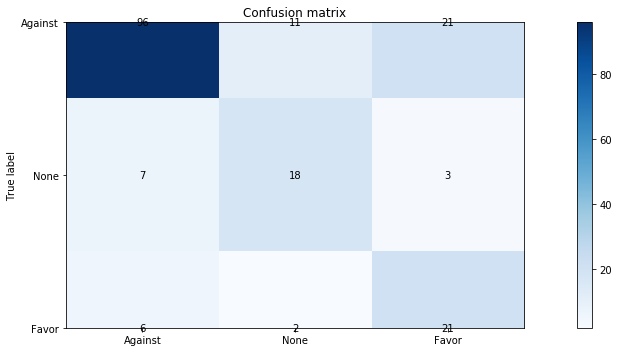

In [22]:
test_probs = model.predict(test_data)
metrics(true_labels, test_probs)

In [24]:
#store predictions and true labels for calculating overall F score later
ath_predictions =  np.argmax(test_probs, axis = 1)
ath_labels = true_labels

In [44]:
##write predictions to csv files
#pd.Series(ath_predictions).to_csv('atheism_preds.csv')
#pd.Series(ath_labels).to_csv('atheism_true.csv')

/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


## Hillary Clinton

In [53]:
train_data, train_labels, test_data, test_labels, true_labels, val_data, val_y = topic_subset(['Hillary Clinton'])

#Start session
compute_class = compute_class_weight('balanced', np.unique(true_labels), true_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

model = bert_model_seq(max_length = max_length, 
                     train_layers=6, 
                     optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                                         beta_1 = 0.9,
                                                         beta_2 = 0.999),
                     dropout_rate= 0.5)

# Instantiate variables
initialize_vars(sess)

model.fit(
    train_data, 
    train_labels,
    validation_data = [val_data, val_y],
    epochs=12,
    verbose=1,
    batch_size=32,
    class_weight = weights)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer__seq_10 (BertLayer_S (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]         

F1 macro score (Favor and Against only) 0.6432539682539683
              precision    recall  f1-score   support

     Against       0.84      0.73      0.78       150
        None       0.57      0.79      0.66        63
       Favor       0.55      0.47      0.51        34

   micro avg       0.71      0.71      0.71       247
   macro avg       0.65      0.66      0.65       247
weighted avg       0.73      0.71      0.71       247



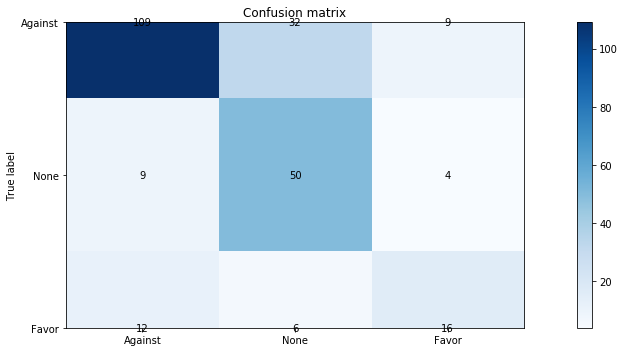

In [54]:
test_probs = model.predict(test_data)
metrics(true_labels, test_probs)

In [55]:
#store predictions and true labels for calculating overall F score later
hil_predictions =  np.argmax(test_probs, axis = 1)
hil_labels = true_labels

In [56]:
##write predictions to csv files
#pd.Series(hil_predictions).to_csv('hil_preds.csv')
#pd.Series(hil_labels).to_csv('hil_true.csv')

/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


## Abortion

In [32]:
train_data, train_labels, test_data, test_labels, true_labels, val_data, val_y = topic_subset(['Legalization of Abortion'])

#Start session
compute_class = compute_class_weight('balanced', np.unique(true_labels), true_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

model = bert_model_seq(max_length = max_length, 
                     train_layers=6, 
                     optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                                         beta_1 = 0.9,
                                                         beta_2 = 0.999),
                     dropout_rate= 0.5)

# Instantiate variables
initialize_vars(sess)


model.fit(
    train_data, 
    train_labels,
    validation_data = [val_data, val_y],
    epochs=15,
    verbose=1,
    batch_size=32,
    class_weight = weights)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer__seq_5 (BertLayer_Se (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

F1 macro score (Favor and Against only) 0.6394927536231885
              precision    recall  f1-score   support

     Against       0.83      0.60      0.70       161
        None       0.35      0.65      0.45        37
       Favor       0.51      0.68      0.58        41

   micro avg       0.62      0.62      0.62       239
   macro avg       0.56      0.64      0.58       239
weighted avg       0.70      0.62      0.64       239



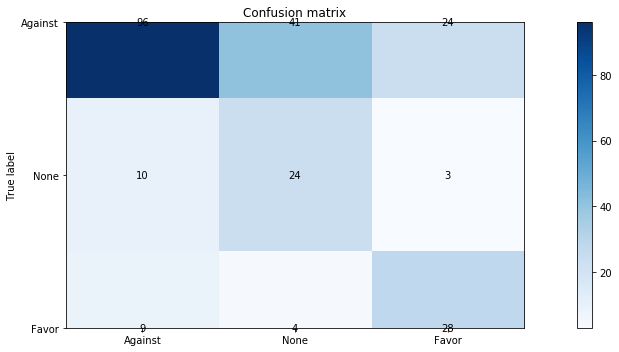

In [33]:
test_probs = model.predict(test_data)
metrics(true_labels, test_probs)

In [36]:
#store predictions and true labels for calculating overall F score later
abort_predictions =  np.argmax(test_probs, axis = 1)
abort_labels = true_labels

In [37]:
##write predictions to csv files
#pd.Series(abort_predictions).to_csv('abort_preds.csv')
#pd.Series(abort_labels).to_csv('abort_true.csv')

/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


## Climate Change

In [21]:
train_data, train_labels, test_data, test_labels, true_labels, val_data, val_y = topic_subset(['Climate Change is a Real Concern'])

#Start session
compute_class = compute_class_weight('balanced', np.unique(true_labels), true_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

model = bert_model_seq(max_length = max_length, 
                     train_layers=6, 
                     optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                                         beta_1 = 0.9,
                                                         beta_2 = 0.999),
                     dropout_rate= 0.5)

# Instantiate variables
initialize_vars(sess)


model.fit(
    train_data, 
    train_labels,
    validation_data = [val_data, val_y],
    epochs=7,
    verbose=1,
    batch_size=32,
    class_weight = weights)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer__seq_3 (BertLayer_Se (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

F1 macro score (Favor and Against only) 0.4950278923114237
              precision    recall  f1-score   support

     Against       0.11      0.10      0.11        10
        None       0.78      0.58      0.67        24
       Favor       0.86      0.91      0.88       105

   micro avg       0.80      0.80      0.80       139
   macro avg       0.58      0.53      0.55       139
weighted avg       0.79      0.80      0.79       139



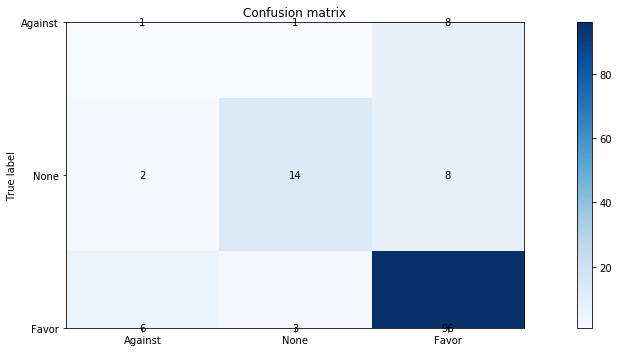

In [22]:
test_probs = model.predict(test_data)
metrics(true_labels, test_probs)

In [25]:
#store predictions and true labels for calculating overall F score later
clim_predictions =  np.argmax(test_probs, axis = 1)
clim_labels = true_labels

In [26]:
##write predictions to csv files
#pd.Series(clim_predictions).to_csv('clim_preds.csv')
#pd.Series(clim_labels).to_csv('clim_true.csv')

/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


## Feminism

In [27]:
train_data, train_labels, test_data, test_labels, true_labels, val_data, val_y = topic_subset(['Feminist Movement'])

#Start session
compute_class = compute_class_weight('balanced', np.unique(true_labels), true_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

model = bert_model_seq(max_length = max_length, 
                     train_layers=6, 
                     optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                                         beta_1 = 0.9,
                                                         beta_2 = 0.999),
                     dropout_rate= 0.5)

# Instantiate variables
initialize_vars(sess)


model.fit(
    train_data, 
    train_labels,
    validation_data = [val_data, val_y],
    epochs=15,
    verbose=1,
    batch_size=32,
    class_weight = weights)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer__seq_4 (BertLayer_Se (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

F1 macro score (Favor and Against only) 0.5312994915395516
              precision    recall  f1-score   support

     Against       0.77      0.58      0.66       159
        None       0.49      0.68      0.57        37
       Favor       0.34      0.50      0.40        52

   micro avg       0.58      0.58      0.58       248
   macro avg       0.53      0.58      0.54       248
weighted avg       0.64      0.58      0.59       248



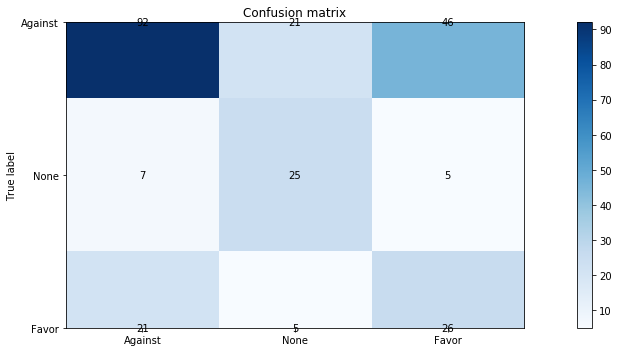

In [28]:
test_probs = model.predict(test_data)
metrics(true_labels, test_probs)

In [30]:
#store predictions and true labels for calculating overall F score later
fem_predictions =  np.argmax(test_probs, axis = 1)
fem_labels = true_labels

In [31]:
##write predictions to csv files
#pd.Series(fem_predictions).to_csv('fem_preds.csv')
#pd.Series(fem_labels).to_csv('fem_true.csv')

/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


## Overall Performance

F1 macro score (Favor and Against only) 0.6841072109851525
              precision    recall  f1-score   support

     Against       0.82      0.65      0.72       608
        None       0.51      0.69      0.59       189
       Favor       0.59      0.72      0.65       261

    accuracy                           0.67      1058
   macro avg       0.64      0.69      0.65      1058
weighted avg       0.70      0.67      0.68      1058



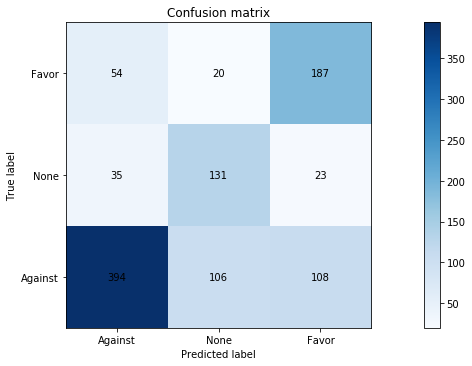

In [3]:
#read in predictions
aethism_preds = pd.read_csv('final_outputs/atheism_preds.csv',header = None, index_col = 0).values
hil_preds = pd.read_csv('final_outputs/hil_preds.csv', header = None, index_col = 0).values
abort_preds = pd.read_csv('final_outputs/abort_preds.csv',header = None, index_col = 0).values
clim_preds = pd.read_csv('final_outputs/clim_preds.csv', header = None, index_col = 0).values
fem_preds = pd.read_csv('final_outputs/fem_preds.csv', header = None, index_col = 0).values

#read in true labels
aethism_labels = pd.read_csv('final_outputs/atheism_true.csv',header = None, index_col = 0).values
hil_labels = pd.read_csv('final_outputs/hil_true.csv', header = None, index_col = 0).values
abort_labels = pd.read_csv('final_outputs/abort_true.csv',header = None, index_col = 0).values
clim_labels = pd.read_csv('final_outputs/clim_true.csv', header = None, index_col = 0).values
fem_labels = pd.read_csv('final_outputs/fem_true.csv', header = None, index_col = 0).values

#stack and reshape
all_preds = np.vstack((aethism_preds, hil_preds, abort_preds, clim_preds, fem_preds))
all_preds = np.reshape(all_preds, (all_preds.shape[0],))

all_labels = np.vstack((aethism_labels, hil_labels, abort_labels, clim_labels, fem_labels))
all_labels = np.reshape(all_labels, (all_labels.shape[0],))

#metrics
#calculate f1 score and print classification report
class_report = classification_report(y_true = all_labels, 
                                        y_pred = all_preds,
                                        target_names = ['Against', 'None', 'Favor'], output_dict=True)
    
print("F1 macro score (Favor and Against only)", str((class_report['Favor']['f1-score'] + 
         class_report['Against']['f1-score']) / 2))
    
print(classification_report(y_true = all_labels, 
                                        y_pred = all_preds,
                                        target_names = ['Against', 'None', 'Favor']))
    
confuse = confusion_matrix(y_true = all_labels, y_pred = all_preds)
    
plt.figure(figsize=(15, 5))
confusion_plot(confuse, ['Against', 'None', 'Favor'])
plt.show()

## ALL

In [ ]:
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Hillary Clinton', 
                                                                              'Legalization of Abortion', 
                                                                              'Climate Change is a Real Concern',
                                                                             'Atheism',
                                                                             'Feminist Movement'])


#Start session
compute_class = compute_class_weight('balanced', np.unique(true_labels), true_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

model = bert_model_2(max_length, train_layers=12, optimizer = 'adam')

# Instantiate variables
initialize_vars(sess)


model.fit(
    train_data, 
    train_labels,
    validation_data=[test_data, test_labels],
    epochs=20,
    verbose=1,
    batch_size=32,
    class_weight = weights)

In [ ]:
test_probs = model.predict(test_data)
metrics(true_labels, test_probs)